## mRPI Decomposed

In this notebook we consider an idea for estimating the mRPI set using a compositional approach.

References:

- [1] *Invariant Approximations of the Minimal Robust Positively Invariant Set*. S. V. Rakovic, E. C. Kerrigan, K. I. Kouramas, and D. Q. Mayne, https://ieeexplore.ieee.org/document/1406138
- [2] Bogomolov, S., Forets, M., Frehse, G., Viry, F., Podelski, A., & Schilling, C. (2018, April). Reach set approximation through decomposition with low-dimensional sets and high-dimensional matrices. In Proceedings of the 21st International Conference on Hybrid Systems: Computation and Control (part of CPS Week) (pp. 41-50). ACM. , https://arxiv.org/abs/1801.09526

Consider the discrete-time dynamical system $x^+ = Ax + w$, where $A$ is strictly stable, and $w \in W$ where $W$ is a compact set that contains the origin. The associated robust positively invariant set is defined as
$$
F_\infty = \bigoplus_{i=0}^\infty A^i W,
$$
where $A^0 := I_n$. However, this set cannot be computed exactly in general, and one should consider either inner or outer approximations. For any $s \geq 0$, let
$$
F_s := \bigoplus_{i=0}^{s-1} A^i W,\qquad F_0 := \{ 0\}.
$$

In [Theorem 2-3, 1] a method is proposed such that for any given $\varepsilon > 0$ it computes $\alpha \in \mathbb{R}$ and $s > 1$ such that if $F(s, \alpha) := (1-\alpha)^{-1}F_s$, the following holds:

$$
F_\infty \subseteq F(s, \alpha) \subseteq F_\infty \oplus B_p^n(\varepsilon).
$$
Moreover, $F(s, \alpha)$ is a robust positively invariant set of $x^+ = Ax + w$.

## Decomposed recurrence

The first terms of sequence $\{ F_s \}_{s\geq 1}$ are $F_0 = \{0_n\}$, $F_1 = W$, $F_2 = W\oplus AW$, $F_3 = W\oplus AW \oplus A^2 W$, etc.

The non-decomposed version of this recurrence, identifying with the time-variant inputs case in [2], is

$$
X_k = X_0 \oplus V_k \\
V_{k+1} = V_k \oplus A^k W
$$
where $k\geq 0$, and $X_0 = \{0_n\}$ and $V_0 = \{0_n\}$. Then, $X_0 = \{0_n\}$, $X_1 = W$, $X_2 = W \oplus AW$, $X_3 = W \oplus AW \oplus A^2 W$, etc.

For different ways of computing the non-decomposed recurrence for a given order $s$ see the notebook `mRPI.ipynb`.

We consider next the *decomposed* recurrence. Let $dcp(\cdot)$ denote the Cartesian decomposition function, $\textrm{dcp}(X) = \times_{j} \pi_j X$ where $j$ runs through as many indices as blocks of variables are considered in the decomposition.

$$
\hat{X}_{i, k} = \hat{V}_{i, k} \\
\hat{V}_{i, k+1} = \hat{V}_{i, k} \oplus \textrm{dcp}_i (A^k W),
$$
$k \geq 1$, and $\hat{V}_{0} = \{0_n\}$. Here $i = 1,\ldots, b$. Note that the first term of the decomposed recurrence are
$$
\hat{X}_{i, 1} = \hat{V}_{i, 1} = \hat{V}_{i, 0} \oplus \textrm{dcp}_i (A^0 W) = \textrm{dcp}_i (W)
$$
$$
\hat{X}_{i, 2} = \hat{V}_{i, 2} = \hat{V}_{i, 1} \oplus \textrm{dcp}_i (A W) = \textrm{dcp}_i (W) \oplus \textrm{dcp}_i (AW)
$$
$$
\hat{X}_{i, 3} = \hat{V}_{i, 3} = \hat{V}_{i, 2} \oplus \textrm{dcp}_i (A^2 W) = \textrm{dcp}_i (W) \oplus \textrm{dcp}_i (AW) \oplus \textrm{dcp}_i (A^2W)
$$

In general,

$$
\hat{X}_{i, k} = \bigoplus_{j=0}^{k-1} \textrm{dcp}_i(A^j W),\qquad k \geq 1, ~i = 1,\ldots b.
$$

## Implementation of the decomposed recurrence

In [55]:
using LazySets, LazySets.Approximations

A = [-1/2 1.0; 0.0 1/2.0]

2×2 Array{Float64,2}:
 -0.5  1.0
  0.0  0.5

In [59]:
W = BallInf(zeros(2), 1.0) # this is already decomposed, but it does not need to be the case in general

BallInf{Float64}([0.0, 0.0], 1.0)

In [60]:
X̂1 = decompose(W, [[1], [2]], Interval)

CartesianProductArray{Float64,LazySet{Float64}}(LazySet{Float64}[Interval{Float64,Interval{Float64}}([-1, 1]), Interval{Float64,Interval{Float64}}([-1, 1])])

In [61]:
b = 2 # number of blocks
dcp_AjW(k) = [decompose(A^j * W, [[i] for i in 1:b], Interval) for j = 0:k-1];

In [62]:
D = dcp_AjW(4)
X̂4 = CartesianProductArray([reduce(minkowski_sum, [array(D[j])[i] for j in 1:length(D)]) for i in 1:b])

CartesianProductArray{Float64,Zonotope{Float64}}(Zonotope{Float64}[Zonotope{Float64}([0.0], [1.0 1.5 0.25 0.375]), Zonotope{Float64}([0.0], [1.0 0.5 0.25 0.125])])

In [63]:
# computation using Zonotopes
Wzono = convert(Zonotope, W)

X1 = Wzono
X2 = minkowski_sum(X1, linear_map(A, Wzono))
X3 = minkowski_sum(X2, linear_map(A^2, Wzono))
X4 = minkowski_sum(X3, linear_map(A^3, Wzono))

Zonotope{Float64}([0.0, 0.0], 
  [1, 1]  =  1.0
  [2, 2]  =  1.0
  [1, 3]  =  -0.5
  [1, 4]  =  1.0
  [2, 4]  =  0.5
  [1, 5]  =  0.25
  [2, 6]  =  0.25
  [1, 7]  =  -0.125
  [1, 8]  =  0.25
  [2, 8]  =  0.125)

In [64]:
using Plots

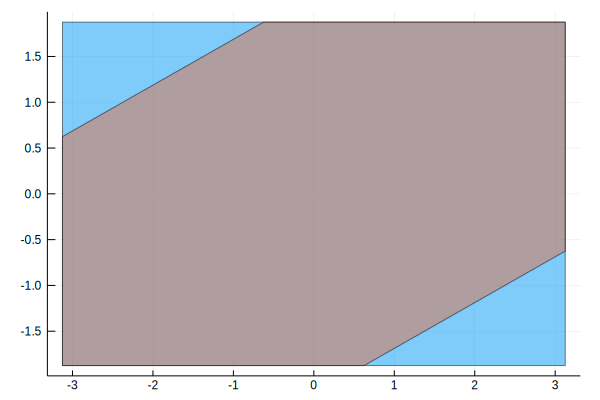

In [65]:
plot(X̂4)
plot!(X4)

## Error estimate

- `k=1`: $X_1 = W$ and $\hat{X}_1 = \textrm{dcp}(W)$, then $d_H(\hat{X}_1, X_1) = \gamma$ where $\gamma := d_H(\textrm{dcp}(W), W) = d_H(\hat{W}, W)$ where $\hat{W} := \textrm{dcp}(W)$.
- `k=2`: $X_2 = W \oplus AW$ and $\hat{X}_2 = \textrm{dcp}(W) \oplus \textrm{dcp}(AW)$
- `k=3`: $X_2 = W \oplus AW \oplus A^2 W$ and $\hat{X}_2 = \textrm{dcp}(W) \oplus \textrm{dcp}(AW) \oplus \textrm{dcp}(A^2 W)$

Note that decomposition distributes over Minkowski sum. Then we can equally do:

$$
\hat{X}_2 = \textrm{dcp}(W \oplus AW \oplus A^2 W).
$$

$d_H(X_2, \hat{X}_2) = d_H(W \oplus AW, \textrm{dcp}(W) \oplus \textrm{dcp}(AW))$

Let's try to bound this term:

$$
d_H(X_2, \hat{X}_2) = d_H(W \oplus AW, \textrm{dcp}(W) \oplus \textrm{dcp}(AW))\\
= d_H(W \oplus AW, \hat{W} \oplus \textrm{dcp}(AW))\qquad (1)
$$

Then we can upper bound it using the following property:

$d_H(A\oplus B, C \oplus D) \leq d_H(A\oplus C) + d_H(B \oplus D)\qquad (2)$.

For a proof see for example [Prop. 1.17, S. Hu and N. S. Papageorgiou, Handbook of multivalued analysis. Vol. I, ser. Mathematics and its Applications. Kluwer, 1997, vol. 419.]

From (1) and (2) we have that
$$
d_H(X_2, \hat{X}_2) \leq d_H(W, \hat{W}) + d_H(AW, \textrm{dcp}(AW)).
$$

To simplify let us now assume that the perturbation $W$ is initially decomposed. Then $d_H(W, \hat{W}) = 0$ and

$$
d_H(X_2, \hat{X}_2) \leq d_H(A\hat{W}, \textrm{dcp}(A\hat{W})).
$$

Consider [Prop. 1 and Prop. 2, Bogomolov, S., Forets, M., Frehse, G., Viry, F., Podelski, A., & Schilling, C. (2018, April). Reach set approximation through decomposition with low-dimensional sets and high-dimensional matrices. In Proceedings of the 21st International Conference on Hybrid Systems: Computation and Control (part of CPS Week) (pp. 41-50). ACM.]:

$$
    d_H(\Phi \hat{X}, \textrm{dcp}(\Phi \hat{X})) \leq (b-1) \sum_{j=1}^b \alpha_j \Delta_j,
$$
where $b$ is the number of blocks, $q_j = \textrm{arg max}_i \Vert \Phi_{ij} \Vert_p$ the index of the block with largest matrix norm in the $j$-th column block, so that $\alpha_j := \max_{i \neq q_j} \Vert \Phi_{ij} \Vert_p$ is the second largest matrix norm in the $j$-th column-block, and $\Delta_j$ is the diameter of $\hat{X}_j$.

Then under the running assumptions,

$$
d_H(X_2, \hat{X}_2) \leq (b-1) \sum_{j=1}^b \alpha_j \Delta_j.
$$
where $\alpha_j := \max_{i \neq q_j} \Vert A{ij} \Vert_p$ with $q_j$ as defined above, and $\Delta_j$ is the diameter of $\hat{W}_j$.

## Questions

- Is $\hat{F}(s, \alpha)$ also a positively invariant set?
- Work out the case where $W$ is not initially decomposed.
- Work out the general case (higher order $s$).